In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy.special import expit
import itertools

## Bayesian Networks

In [2]:
from pgmpy.models import BayesianNetwork
from pgmpy.models.BayesianModel import BayesianModel
from pgmpy.inference import VariableElimination
import bnlearn as bn

In [3]:
# 1. Defining network structure

Dag_squeleton = [
        ("Age", "Awareness_CB"),
        ("Age", "CB"),
        ("Age", "Hours_Internet"),
        ("Awareness_CB", "CB"),
        ("Gender", "Awareness_CB"),
        ("Gender", "CB"),
        ("Hours_Internet", "CB"),
        ("Family_Comm", "Awareness_CB"),
        ("Family_Comm", "CB"),
        ("SO", "CB"),
        ("Immigrant_son", "CB")
    ]

CB_model = BayesianNetwork(Dag_squeleton)

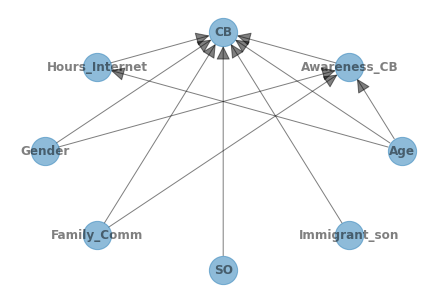

In [4]:
import networkx as nx
nx.draw_circular(
    CB_model, with_labels=True, arrowsize=30, node_size=800, alpha=0.5, font_weight="bold"
)
plt.show()

In [ ]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1YkwAFiT-LoXGFtQWwWvchYco6IKYRkwX', 
                                    dest_path='./Data.zip',
                                    unzip=False)

In [10]:
!unzip Data.zip

Archive:  Data.zip
  inflating: data_ic2s2.csv          


In [11]:
data_BN = pd.read_csv('data_ic2s2.csv')
data_BN.drop(['Family_Superv', 'Family'], axis=1, inplace=True)
data_BN

,Age,Gender,SO,Hours_Internet,Family_Comm,Awareness_CB,Immigrant_son,CB
0,4,0,0,1,2,0,1,0
1,2,0,0,1,1,4,0,0
2,3,1,0,2,3,3,1,0
3,2,0,0,3,3,4,0,1
4,2,1,0,2,2,3,0,0
...,...,...,...,...,...,...,...,...
682,0,1,0,2,0,3,0,0
683,1,0,0,1,0,4,0,0
684,1,0,0,1,3,3,0,0
685,1,0,0,3,3,4,0,1


In [12]:
# 2. Parameter learning from data

from pgmpy import estimators
# MaximumLikelihoodEstimator
# BayesianEstimator
# ExpectationMaximization
# IVEstimator   (Structural Equation)
# SEMEstimator   (Structural Equation)

CB_model.fit(data=data_BN,
             estimator=estimators.BayesianEstimator,
             prior_type="BDeu",
             equivalent_sample_size=1000,
)
CB_model.get_cpds()

[<TabularCPD representing P(Age:5) at 0x7f4ed25e6d90>,
 <TabularCPD representing P(Awareness_CB:5 | Age:5, Family_Comm:4, Gender:2) at 0x7f4e3ebb1f90>,
 <TabularCPD representing P(CB:2 | Age:5, Awareness_CB:5, Family_Comm:4, Gender:2, Hours_Internet:4, Immigrant_son:2, SO:2) at 0x7f4ed24b1ed0>,
 <TabularCPD representing P(Hours_Internet:4 | Age:5) at 0x7f4e3ebb1890>,
 <TabularCPD representing P(Gender:2) at 0x7f4e3ebb1410>,
 <TabularCPD representing P(Family_Comm:4) at 0x7f4e3f2837d0>,
 <TabularCPD representing P(SO:2) at 0x7f4e3f283550>,
 <TabularCPD representing P(Immigrant_son:2) at 0x7f4e3f283610>]

In [13]:
# 3.1 Inference probabilities based on observations (Exact Inference)

from pgmpy.inference import VariableElimination
#  https://pgmpy.org/exact_infer/ve.html#

inferencer = VariableElimination(CB_model)

evidence_CB = {'Gender': 0,        # Gender = Male
               'Age': 2,           # Age = 15
               'SO': 1,            # SO = Non_Heterosexual
               'Immigrant_son': 0  # Immigrant_son = Non_Immigrant   
              }

CB_inference = inferencer.query(['CB'], evidence=evidence_CB)
print(CB_inference)
print(CB_inference.get_value(CB=0))

+-------+-----------+
| CB    |   phi(CB) |
+=======+===========+
| CB(0) |    0.5219 |
+-------+-----------+
| CB(1) |    0.4781 |
+-------+-----------+
0.5218538520947759


In [14]:
# 3.2 Inference probabilities based on interventions (Causal Inference)

from pgmpy.inference import CausalInference

inferencer_causal = CausalInference(CB_model)

do_CB = {'Gender': 0,        # Gender = Male
          'Age': 2,           # Age = 15
          'SO': 1,            # SO = Non_Heterosexual
          'Immigrant_son': 0  # Immigrant_son = Non_Immigrant   
        }
CB_inference_causal = inferencer_causal.query(['CB'], do=do_CB)
print(CB_inference_causal)
print(CB_inference_causal.get_value(CB=0))

+-------+-----------+
| CB    |   phi(CB) |
+=======+===========+
| CB(0) |    0.5219 |
+-------+-----------+
| CB(1) |    0.4781 |
+-------+-----------+
0.5218538520947759


In [15]:
# 4. Generate synthetic data 

from pgmpy import sampling
# ApproxInference   https://pgmpy.org/approx_infer/approx_infer.html
# BayesianModelSampling   https://pgmpy.org/approx_infer/bn_sampling.html
# GibbsSampling   https://pgmpy.org/approx_infer/gibbs.html

sampler = sampling.BayesianModelSampling(CB_model)

from pgmpy.factors.discrete import State
evidence_CB = [State('Gender', 0),        # Gender = Male
               State('Age', 2),           # Age = 15
               State('SO', 1),            # SO = Non_Heterosexual
               State('Immigrant_son', 0)  # Immigrant_son = Non_Immigrant   
              ]
sampler.rejection_sample(evidence=evidence_CB, size=4)

  0%|          | 0/4 [00:00<?, ?it/s]

,Age,Awareness_CB,CB,Hours_Internet,Gender,Family_Comm,SO,Immigrant_son
0,2,0,1,3,0,2,1,0
1,2,0,1,1,0,2,1,0
2,2,0,0,0,0,3,1,0
3,2,0,1,2,0,0,1,0


## Simulator

In [16]:
### Inputs 

n_players = 1000

# mean and var of the profile distributions (Gaussians)
profiles_risk = {'safe': [-2, 0.6],
                 'risky': [0.5, 1.2]}

# Prevalences of Demographics
prevalence_gender_lst = [0.5,  # Male
                         0.5]  # Female 
gender_dict = {'Male': 0,
               'Female' : 1}
prevalence_age_lst = [0.2, 0.2, 0.2, 0.2, 0.2]  # 13 / 14 / 15 / 16 / 17
age_dict = {'Age_13': 0,
            'Age_14' : 1,
            'Age_15' : 2,
            'Age_16' : 3,
            'Age_17' : 4}  
prevalence_sex_orient_lst = [0.85,  # Heterosexual / Non Heterosexual
                             0.15]  # Non Heterosexual
sex_orient_dict = {'Heterosexual': 0,
                   'Non_Heterosexual' : 1}  
prevalence_immigrant_lst = [0.75,  # Non_Immigrant
                            0.25]  # Immigrant
immigrant_dict = {'Non_Immigrant': 0,
                  'Immigrant' : 1}                    
                          
# Questions in the game
n_questions = 15
questions_output = {'safe_answer' : 0,
                    'risky_answer': 1}
low_limit_question = 0
high_limit_question = 1


### Create Demographics

def generate_demograpics(prevalence_gender, prevalence_age, prevalence_sex_orient, prevalence_immigrant):
  gender = np.random.choice(list(gender_dict.values()), p=prevalence_gender)
  age = np.random.choice(list(age_dict.values()), p=prevalence_age)
  sex_orient = np.random.choice(list(sex_orient_dict.values()), p=prevalence_sex_orient)
  immigrant = np.random.choice(list(immigrant_dict.values()), p=prevalence_immigrant)

  return gender, age, sex_orient, immigrant

### Causal model aprox
def causal_model(gender, age, sex_orient, immigrant, mode_causal='exact'):
  if mode_causal == 'approx':
    sampler = sampling.BayesianModelSampling(CB_model)
    evidence_CB = [State('Gender', gender),       
                  State('Age', age),          
                  State('SO', sex_orient),           
                  State('Immigrant_son', immigrant)  
                  ]
    CB_sampled = int(sampler.rejection_sample(evidence=evidence_CB, show_progress=False)['CB'].values)
    if CB_sampled == 0:
      profile_label = 'safe'
    else:
      profile_label = 'risky'

  elif mode_causal == 'exact':
    inferencer = VariableElimination(CB_model)
    evidence_CB = {'Gender': gender,        
                    'Age': age,          
                    'SO': sex_orient,           
                    'Immigrant_son': immigrant     
                   }
    CB_inference = inferencer.query(['CB'], evidence=evidence_CB)
    prob_risky = CB_inference.get_value(CB=1)
    prob_safe = 1 - prob_risky
    # Toss a coin
    profile_label = np.random.choice(list(profiles_risk.keys()), p=[prob_safe, prob_risky])

  elif mode_causal == 'causal':
    inferencer_causal = CausalInference(CB_model)
    do_CB = {'Gender': gender,        
              'Age': age,          
              'SO': sex_orient,           
              'Immigrant_son': immigrant     
              }
    CB_inference_causal = inferencer_causal.query(['CB'], do=do_CB)
    prob_risky = CB_inference_causal.get_value(CB=1)
    prob_safe = 1 - prob_risky
    # Toss a coin
    profile_label = np.random.choice(list(profiles_risk.keys()), p=[prob_safe, prob_risky])
  
  risk_params = profiles_risk[profile_label]
  alpha_risk = np.random.normal(risk_params[0], risk_params[1])

  return alpha_risk, profile_label


### Players

class Player:
  def __init__(self, prevalence_gender, prevalence_age, prevalence_sex_orient, prevalence_immigrant, mode_causal):
    self.gender, self.age, self.sex_orient, self.immigrant = generate_demograpics(prevalence_gender, prevalence_age, prevalence_sex_orient, prevalence_immigrant)
    self.alpha_risk, self.risk_profile = causal_model(self.gender, self.age, self.sex_orient, self.immigrant, mode_causal)
  
  def play_game(self, game, mode='2PL_modified'):
    answers_player = []
    for question in game.difficulty_questions:
      if mode == 'weights':
        # Prob. to answer risky = p(i) * (1-W(j)) + 0.5 * W(j)
        prob_answer_risky = self.alpha_risk * (1-question) + 0.5 * question
      elif mode == 'rasch':
        # Prob. to answer risky = 1 / 1+e^(Q-P)
        prob_answer_risky = 1/(1 + math.exp(question - self.alpha_risk))
      elif mode == '2PL_modified':
        # Prob. to answer risky = 1 / 1+e^(-P*Q)
        prob_answer_risky = 1/(1 + math.exp(-(self.alpha_risk) * question))
      prob_answer_safe = 1 - prob_answer_risky
      answer = np.random.choice(list(questions_output.values()), p=[prob_answer_safe, prob_answer_risky])
      answers_player.append(answer)
    # Add risk
    answers_player.append(self.alpha_risk)
    answers_player.append(self.risk_profile)
    # Add demographics
    answers_player.append(self.gender)
    answers_player.append(self.age)
    answers_player.append(self.sex_orient)
    answers_player.append(self.immigrant)

    return answers_player


### Game

class Game:
  def __init__(self, n=10, low=0, high=1):
    self.low_limit = low
    self.high_limit = high
    self.difficulty_questions = np.random.uniform(low=self.low_limit, high=self.high_limit, size=n)
  
  def get_len_game(self):
    return len(self.difficulty_questions)

In [17]:
# Columns names

columns_names = []
dict_types = {}
for j in range(n_questions):
  name = f'Q_{j+1}'
  dict_types[name] = int
  columns_names.append(name)
columns_names.append('alpha_risk')
columns_names.append('risk_label')
columns_names.append('gender')
columns_names.append('age')
columns_names.append('sex_orient')
columns_names.append('immigrant')

## Let's Play!!

In [18]:
# Create game
game_1 = Game(n=n_questions, low=low_limit_question, high=high_limit_question)
lst_players = [Player(prevalence_gender_lst, prevalence_age_lst, prevalence_sex_orient_lst, prevalence_immigrant_lst, mode_causal='exact') for _ in range(n_players)]

In [19]:
# Create Dataframe
Dataset = pd.DataFrame(columns=columns_names)

# Play!
for participant in lst_players:
  answers = participant.play_game(game_1, mode='2PL_modified')
  Dataset.loc[Dataset.shape[0]] = answers

Dataset.to_csv('Synthetic-data_V4.csv')
pd.set_option('display.max_columns', 30)
Dataset

,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8,Q_9,Q_10,Q_11,Q_12,Q_13,Q_14,Q_15,alpha_risk,risk_label,gender,age,sex_orient,immigrant
0,0,1,0,1,0,0,1,1,1,1,1,1,1,0,1,1.795969,risky,1,4,0,0
1,0,0,0,1,1,1,0,1,0,0,1,1,0,1,0,0.052558,risky,0,2,0,0
2,1,1,1,0,0,1,0,1,0,0,0,0,0,0,0,-1.792915,safe,1,1,0,0
3,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,-2.317275,safe,0,0,0,1
4,0,1,0,1,1,1,0,1,1,1,1,0,0,0,1,1.025729,risky,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1,0,1,1,1,1,0,0,1,1,1,0,1,1,1,1.997101,risky,0,3,0,0
996,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,-2.176209,safe,0,2,0,0
997,1,1,0,1,1,0,0,0,1,1,0,1,0,0,1,-0.787946,safe,0,3,0,0
998,0,0,1,1,0,0,0,1,0,0,0,1,1,1,0,0.230129,risky,0,4,1,1


In [20]:
Dataset['risk_label'].value_counts()

safe     517
risky    483
Name: risk_label, dtype: int64

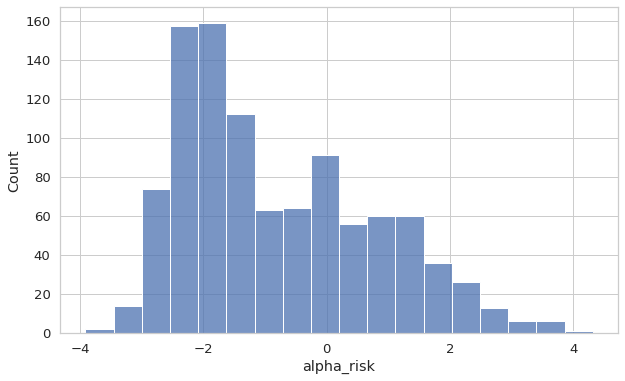

In [21]:
sns.set(font_scale = 1.2)
sns.set_style("whitegrid")
plt.figure(figsize=(10,6))

sns.histplot(Dataset['alpha_risk'], bins='auto')

plt.ylabel('Count')
plt.show()

### Analyze the data

In [22]:
data_1 = Dataset[Dataset.columns[:n_questions]]
questions = [sum(data_1.iloc[:, i]==1) for i in range(data_1.shape[1])]
print(questions)

[392, 420, 400, 345, 454, 376, 368, 499, 374, 349, 437, 435, 402, 470, 419]


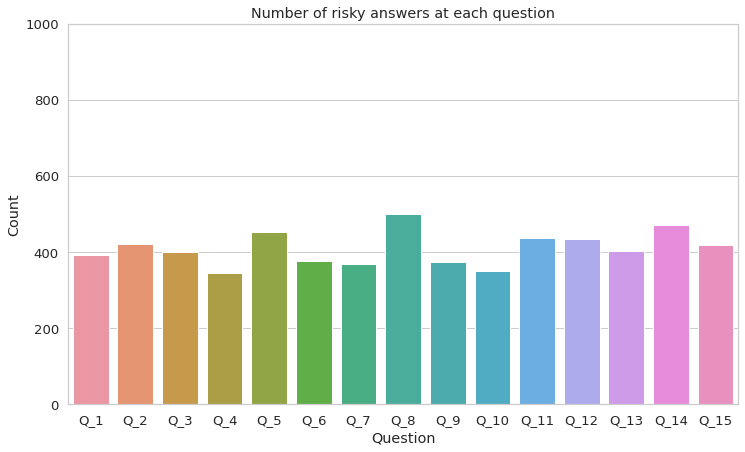

In [23]:
sns.set(font_scale = 1.2)
sns.set_style("whitegrid")
plt.figure(figsize=(12,7))

sns.barplot(x=columns_names[:n_questions], y=questions)

plt.ylim(0,len(data_1))
plt.xlabel('Question')
plt.ylabel('Count')
plt.title('Number of risky answers at each question')
plt.show()

In [24]:
data_sum = data_1.sum(axis=1)

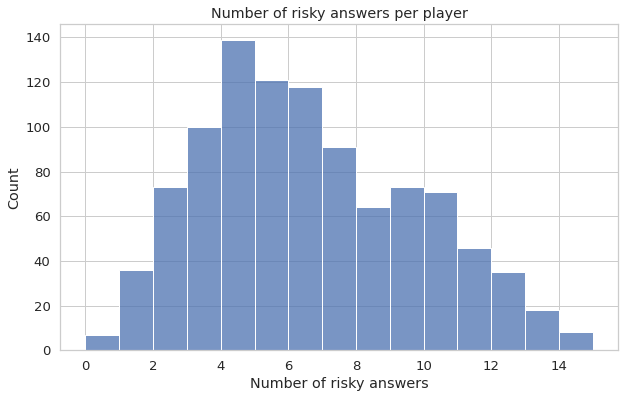

In [25]:
sns.set(font_scale = 1.2)
sns.set_style("whitegrid")
plt.figure(figsize=(10,6))

sns.histplot(data_sum, bins=n_questions)

plt.xlabel('Number of risky answers')
plt.ylabel('Count')
plt.title('Number of risky answers per player')
plt.show()

## Inference: Bayesian ITR Models

In [26]:
import os
import arviz as az
import pymc as pm
print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v4.1.4


In [27]:
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-whitegrid")

In [28]:
n_obs = n_players * n_questions

players = np.array(range(n_players))
questions = np.array(range(n_questions))

# Create array jj
players_obs = []
for i in range(n_players):
  players_obs.extend([i]*n_questions)

# Create array kk
questions_obs = list(range(n_questions))
questions_obs = questions_obs*n_players

# Create array y
answers_obs = list(data_1.values.flatten())

data_bayes = {'J':n_players, 
             'K':n_questions, 
             'N':n_obs, 
             'jj':players_obs, 
             'kk':questions_obs,  
             'y':answers_obs}

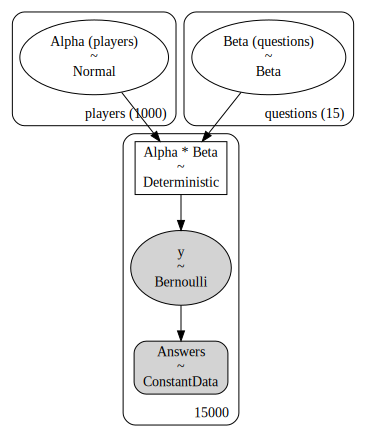

In [29]:
coords = {'players': players, 'questions': questions}

with pm.Model(coords=coords) as model:

    # Data
    answers = pm.Data("Answers", answers_obs, mutable=False)

    # Priors
    alpha = pm.Normal("Alpha (players)", -1, 1.5, dims="players")
    beta = pm.Beta("Beta (questions)", 1, 1, dims="questions")

    # Deterministic
    eta = pm.Deterministic("Alpha * Beta", alpha[players_obs] * beta[questions_obs])

    # Likelihood
    y = pm.Bernoulli("y", logit_p=eta, observed=answers)

pm.model_to_graphviz(model)

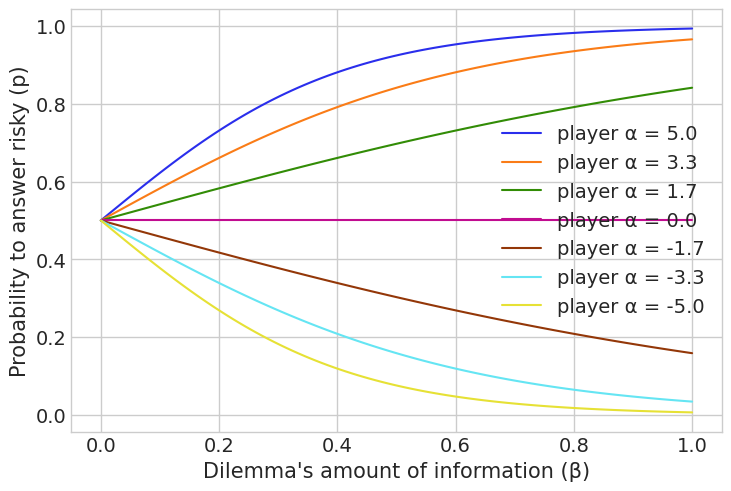

In [30]:
# Visualization 

player = np.linspace(5, -5, 7)
question = np.linspace(0,1,100)

for i,p in enumerate(player):
  y = 1/(1+np.exp(-question*p))
  plt.plot(question, y, label=f'player α = {p:.1f}')
plt.xlabel('Dilemma\'s amount of information (β)')
plt.ylabel('Probability to answer risky (p)')
plt.grid(True)
plt.legend()
plt.show()

In [31]:
with model:
    trace = pm.sample(1000, tune=1500, chains=4, random_seed=RANDOM_SEED)

<AxesSubplot:>

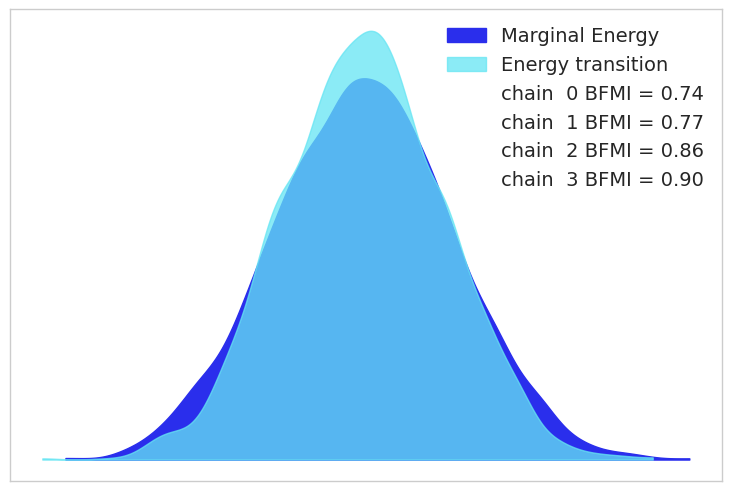

In [32]:
az.plot_energy(trace)

In [33]:
CI = 0.94
func_dict = {
            f'hdi_low_{CI}': lambda x: az.hdi(x, hdi_prob=CI)[0],
            f'hdi_high_{CI}': lambda x: az.hdi(x, hdi_prob=CI)[1]
            }
summary_posteriors = az.summary(trace, stat_funcs=func_dict, extend=True)
summary_posteriors

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,hdi_low_0.94,hdi_high_0.94
Alpha (players)[0],0.741,0.791,-0.715,2.240,0.009,0.011,7716.0,2213.0,1.00,-0.715,2.240
Alpha (players)[1],-0.809,0.768,-2.408,0.500,0.009,0.010,8144.0,2526.0,1.00,-2.408,0.500
Alpha (players)[2],-1.530,0.850,-3.229,0.007,0.010,0.009,8174.0,2876.0,1.00,-3.229,0.007
Alpha (players)[3],-1.954,0.900,-3.657,-0.292,0.010,0.010,7811.0,2686.0,1.00,-3.657,-0.292
Alpha (players)[4],0.254,0.779,-1.203,1.719,0.008,0.014,8440.0,2582.0,1.00,-1.203,1.719
...,...,...,...,...,...,...,...,...,...,...,...
Alpha * Beta[14995],-1.660,0.630,-2.840,-0.516,0.008,0.006,6419.0,2756.0,1.00,-2.840,-0.516
Alpha * Beta[14996],-1.035,0.401,-1.772,-0.287,0.005,0.004,6740.0,2896.0,1.00,-1.772,-0.287
Alpha * Beta[14997],-1.564,0.593,-2.702,-0.500,0.007,0.006,7129.0,3057.0,1.01,-2.702,-0.500
Alpha * Beta[14998],-0.633,0.268,-1.136,-0.148,0.003,0.003,7349.0,2762.0,1.00,-1.136,-0.148


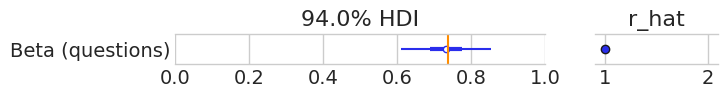

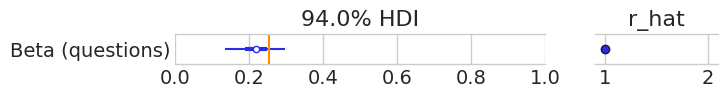

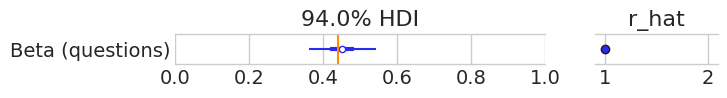

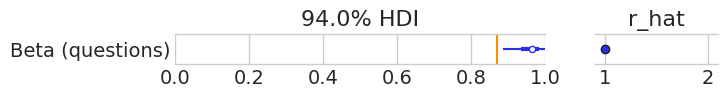

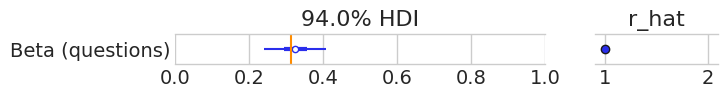

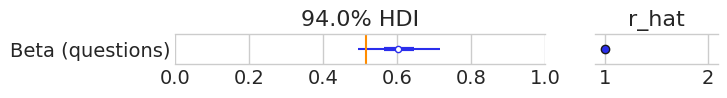

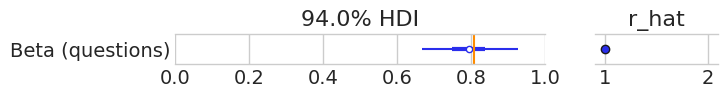

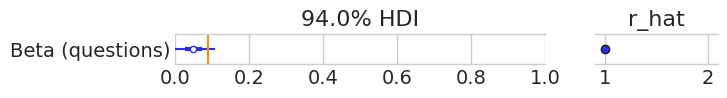

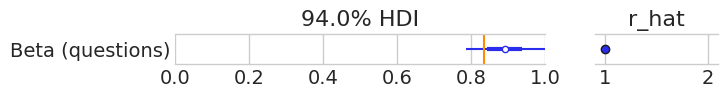

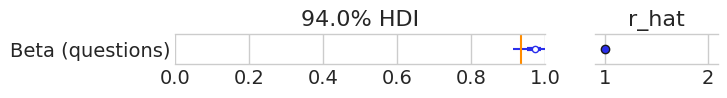

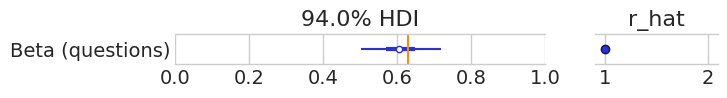

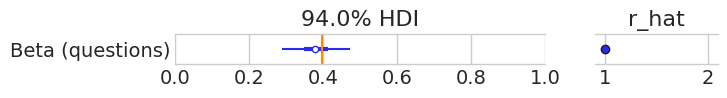

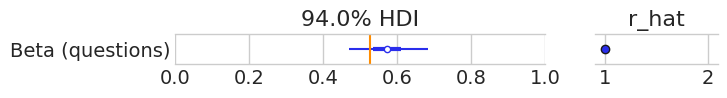

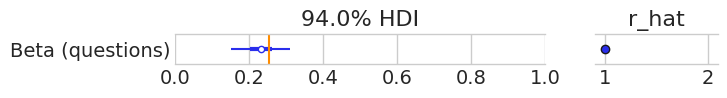

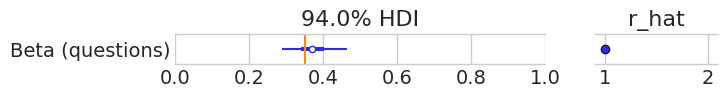

In [38]:
for q in range(n_questions):
  aaa = az.plot_forest(trace.posterior["Beta (questions)"][:,:,q], combined=True, r_hat=True, figsize=(7,0.4))
  aaa[0].vlines(x=game_1.difficulty_questions[q], ymin=-0.4, ymax=0.4, colors=['darkorange'])
  aaa[0].set_xlim([0, 1])
  aaa[0].set_ylim([-0.4, 0.4])

Text(0.5, 1.0, 'Posteriors of Beta parameters (questions)')

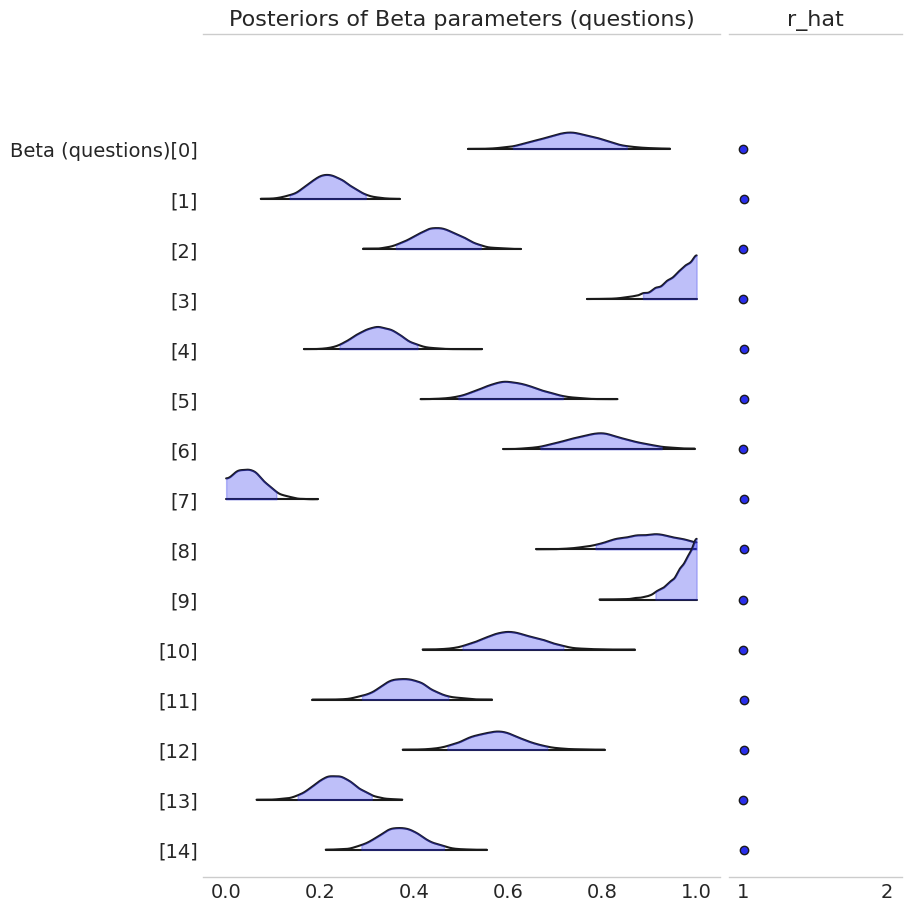

In [37]:
axes = az.plot_forest(trace, var_names=["Beta (questions)"], kind='ridgeplot', combined=True, r_hat=True, ridgeplot_overlap=1, ridgeplot_alpha=0.3, ridgeplot_truncate=False, figsize=(9, 9))
axes[0].set_title('Posteriors of Beta parameters (questions)')
# axes[0].grid(True)
# axes[1].grid(True)

### Results

In [40]:
means_players_pred = summary_posteriors['mean'][:n_players]

y_true = Dataset.loc[:,'alpha_risk']
y_true_profile = Dataset.loc[:,'risk_label']

In [41]:
print('PREDICTION PLAYERS:\n')

from collections import Counter

bingos = []
for i in range(n_players):
  hdi_low = summary_posteriors.iloc[i][f'hdi_low_{CI}']
  hdi_high = summary_posteriors.iloc[i][f'hdi_high_{CI}']
  assert hdi_low < hdi_high
  if hdi_low <= y_true[i] <= hdi_high:
    bingos.append('CORRECT')
  else:
    bingos.append('ERROR')
count_bingos = Counter(bingos)
print(count_bingos)
acc = count_bingos['CORRECT']/len(bingos)
print(f'Accuracy = {acc:.3f}')

PREDICTION PLAYERS:

Counter({'CORRECT': 930, 'ERROR': 70})
Accuracy = 0.930


In [42]:
print('PREDICTION QUESTIONS:\n')

from collections import Counter

bingos_q = []
for i in range(n_questions):
  hdi_low = summary_posteriors.loc[f'Beta (questions)[{i}]'][f'hdi_low_{CI}']
  hdi_high = summary_posteriors.loc[f'Beta (questions)[{i}]'][f'hdi_high_{CI}']
  assert hdi_low < hdi_high
  if hdi_low <= game_1.difficulty_questions[i] <= hdi_high:
    bingos_q.append('CORRECT')
  else:
    bingos_q.append('ERROR')
count_bingos_q = Counter(bingos_q)
print(count_bingos_q)
acc = count_bingos_q['CORRECT']/len(bingos_q)
print(f'Accuracy = {acc:.3f}')

PREDICTION QUESTIONS:

Counter({'CORRECT': 14, 'ERROR': 1})
Accuracy = 0.933


### Plots



CORRECT


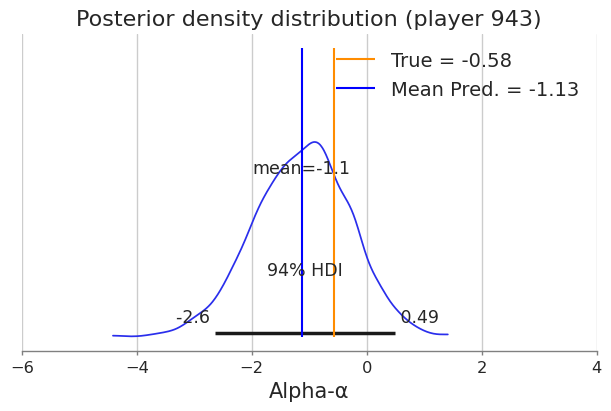

CORRECT


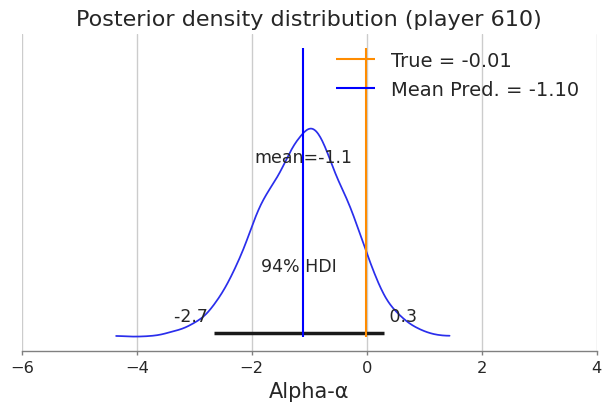

CORRECT


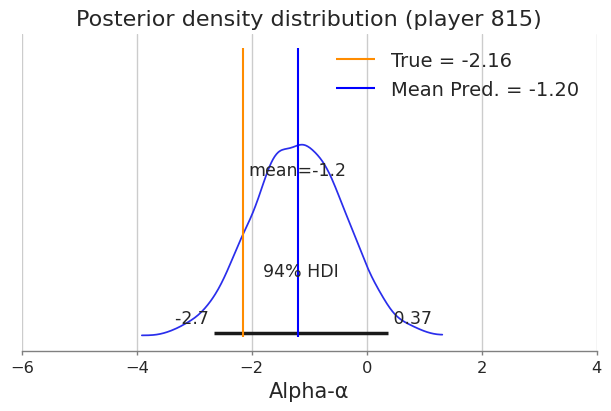

CORRECT


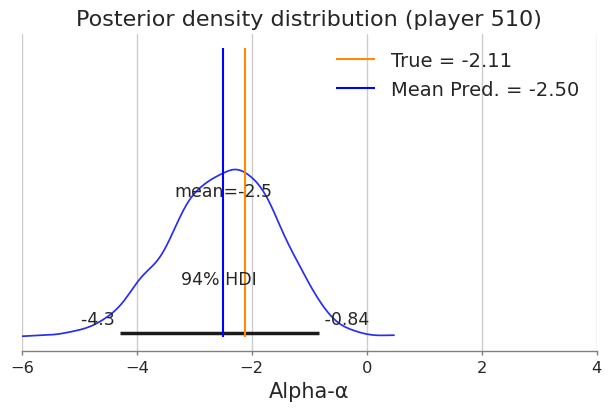

CORRECT


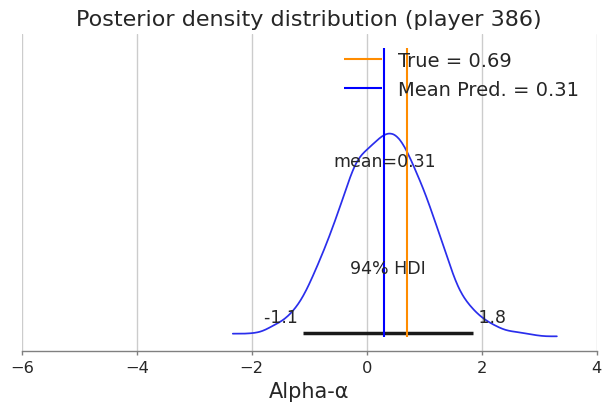

CORRECT


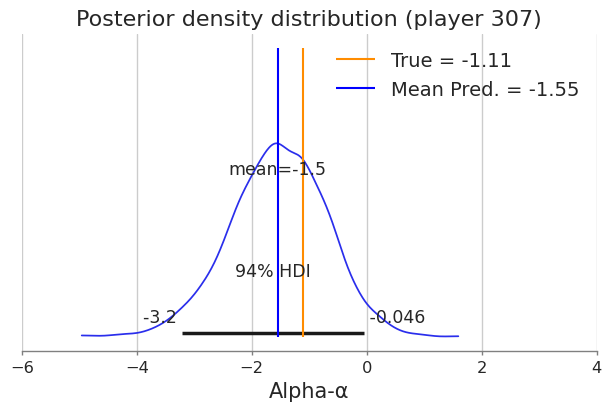

CORRECT


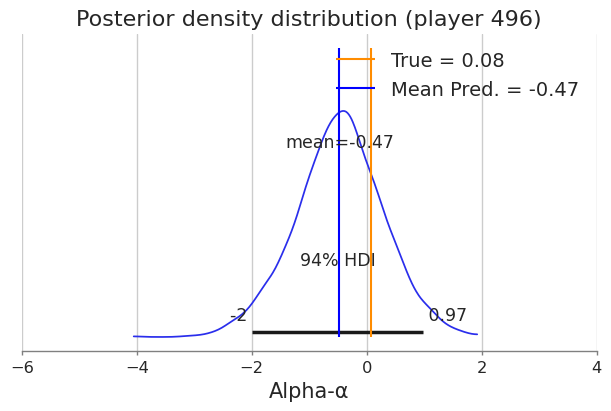

CORRECT


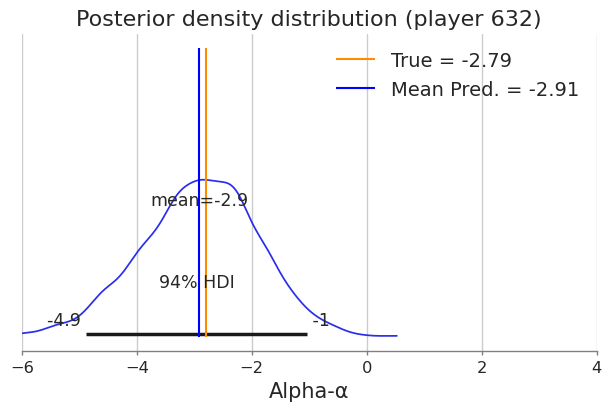

CORRECT


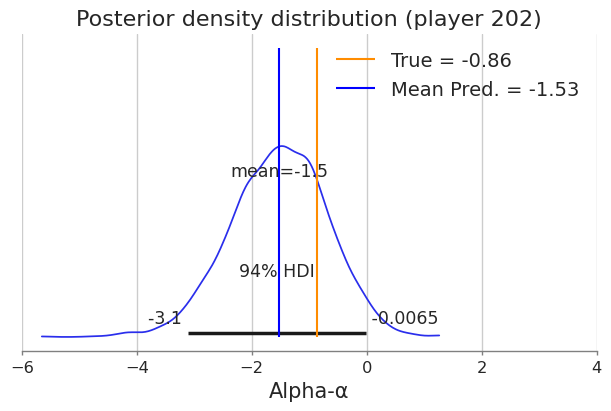

CORRECT


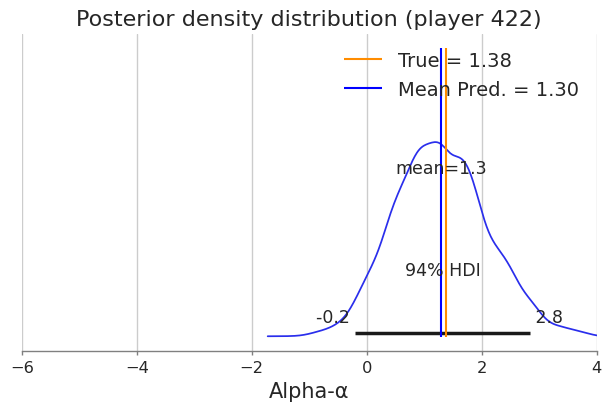

CORRECT


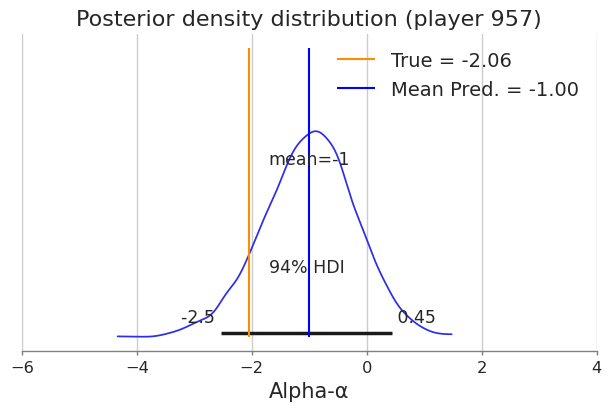

ERROR


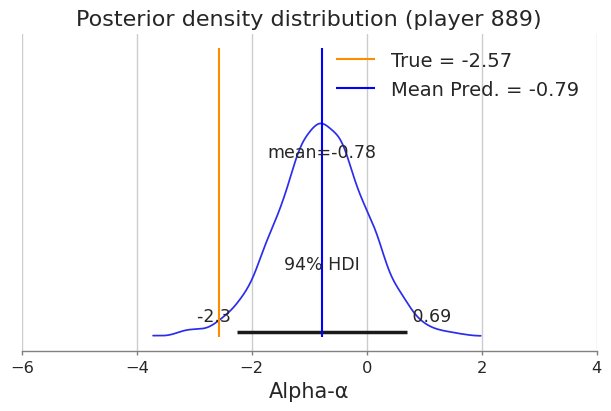

CORRECT


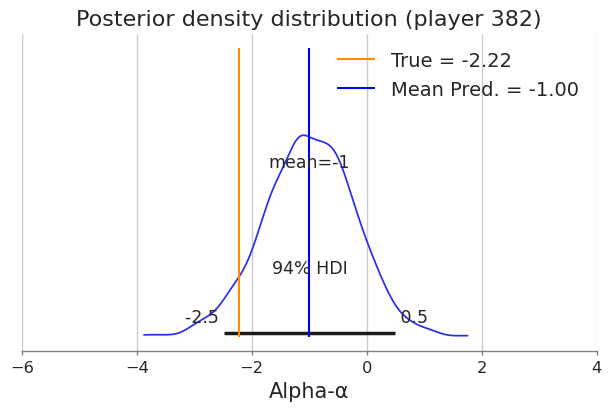

CORRECT


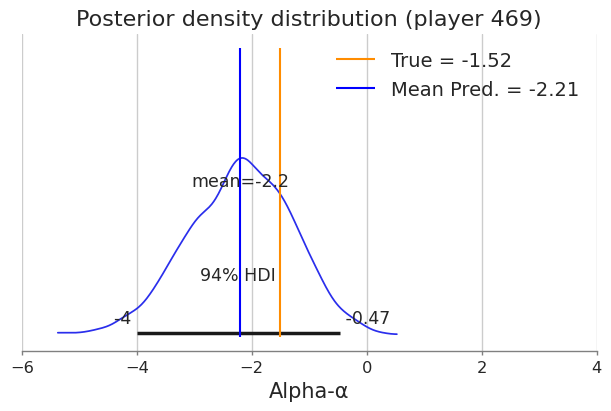

CORRECT


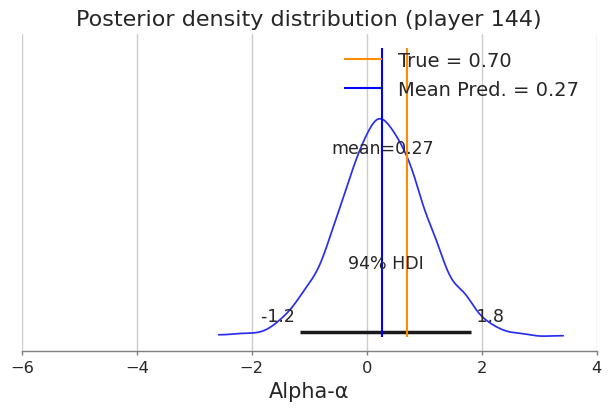

CORRECT


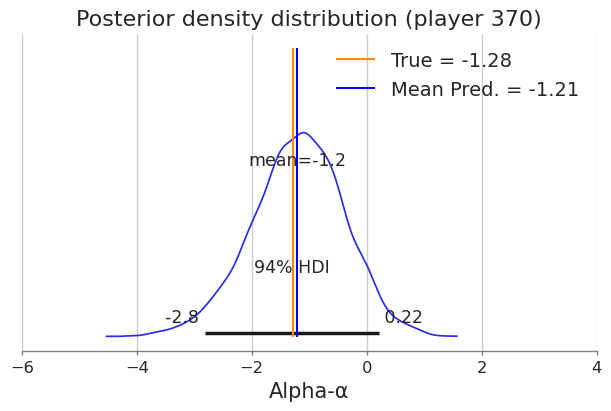

CORRECT


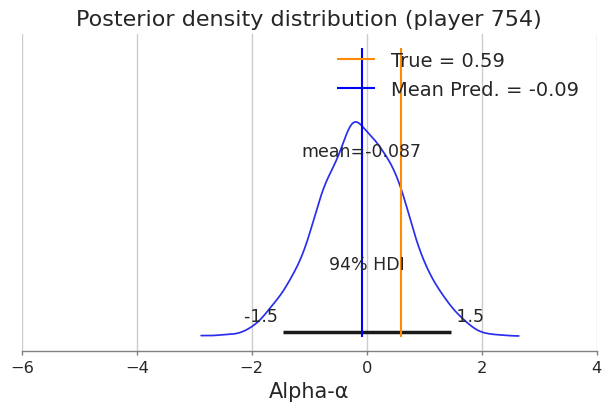

CORRECT


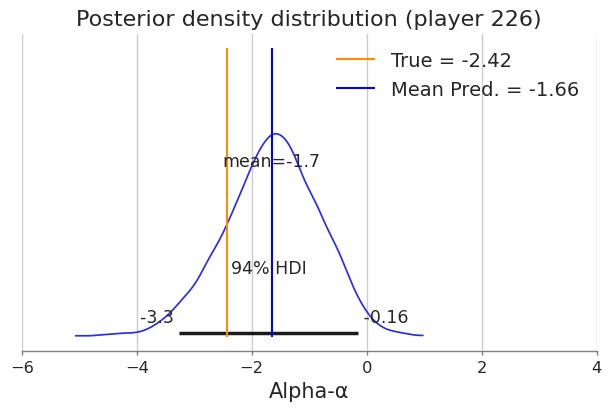

CORRECT


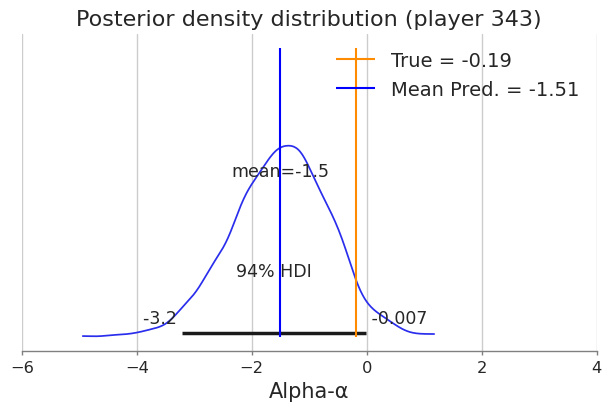

ERROR


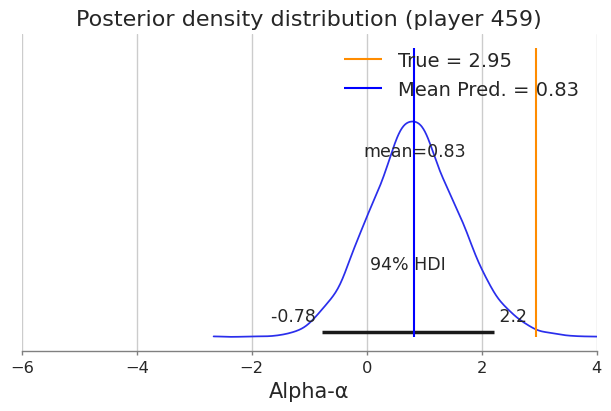

In [43]:
# Plot 20 (randomly selected) players' posteriors 
players_plot = np.random.randint(0, n_players, size=20)

for i in players_plot:
    hdi_low = summary_posteriors.iloc[i][f'hdi_low_{CI}']
    hdi_high = summary_posteriors.iloc[i][f'hdi_high_{CI}']
    if hdi_low <= y_true[i] <= hdi_high:
      print('\033[1m' + '\033[92m' + 'CORRECT' + '\033[92m' + '\033[0m')
    else:
      print('\033[1m' + '\033[91m' + 'ERROR' + '\033[91m' + '\033[0m')
    # print(hdi_low, hdi_high)
    # print(bingos[i])
    player_draws = trace.posterior['Alpha (players)'][:, :, i]
    az.plot_posterior(player_draws, hdi_prob=CI, figsize=(6,4))
    x_line = y_true[i]
    plt.vlines(x=x_line, ymin=0, ymax=0.7, colors=['darkorange'], label=f'True = {x_line:.2f}')
    x_line_pred = summary_posteriors['mean'][i]
    plt.vlines(x=x_line_pred, ymin=0, ymax=0.7, colors=['blue'], label=f'Mean Pred. = {x_line_pred:.2f}')
    plt.legend(loc='best')
    plt.xlabel('Alpha-α')
    plt.xlim([-6, 4])
    plt.title(f'Posterior density distribution (player {i})')
    plt.grid(True)
    plt.show()

CORRECT


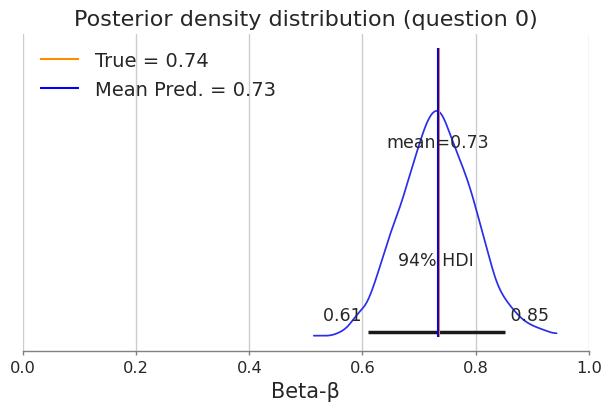

CORRECT


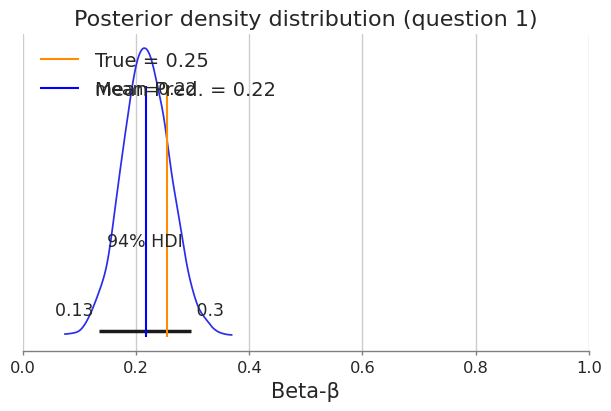

CORRECT


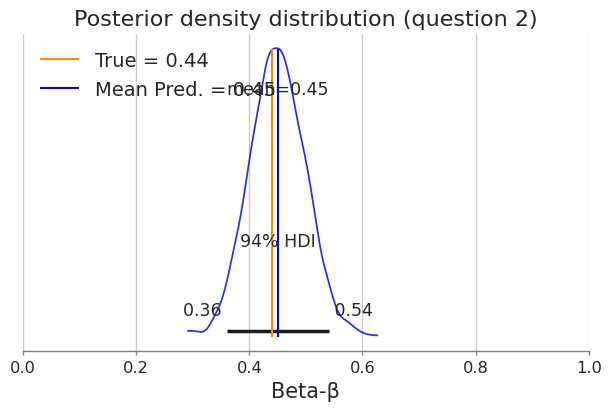

ERROR


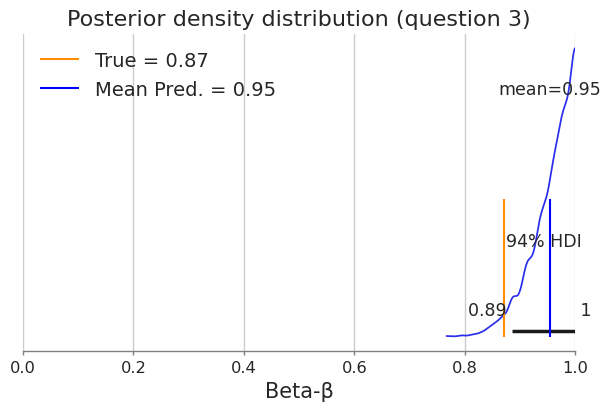

CORRECT


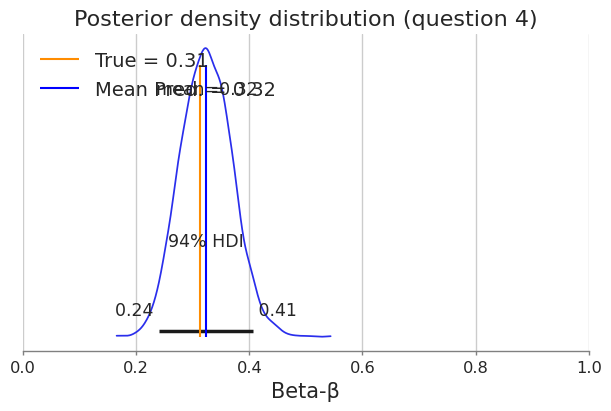

CORRECT


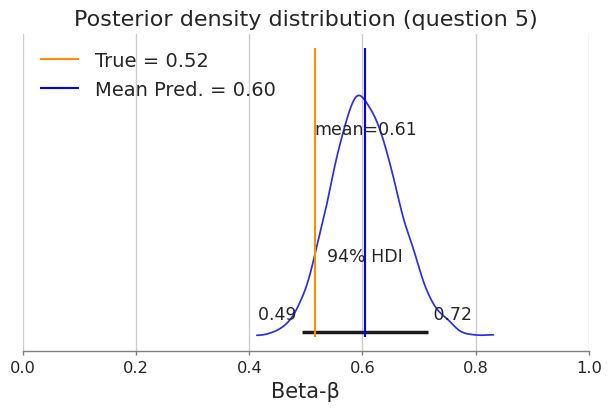

CORRECT


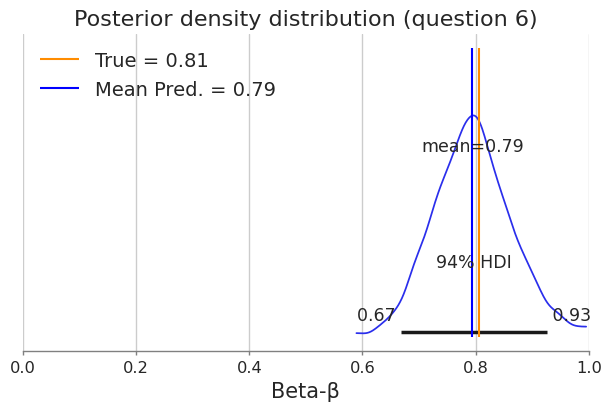

CORRECT


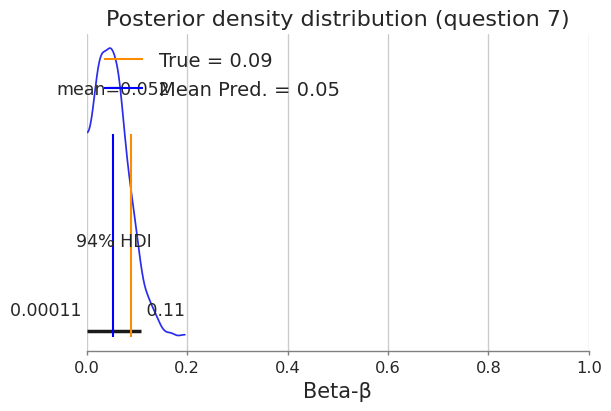

CORRECT


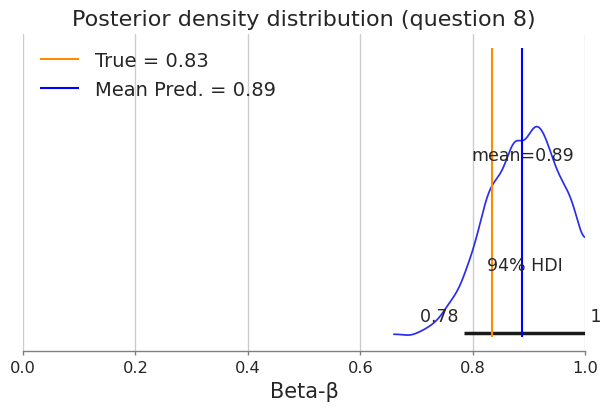

CORRECT


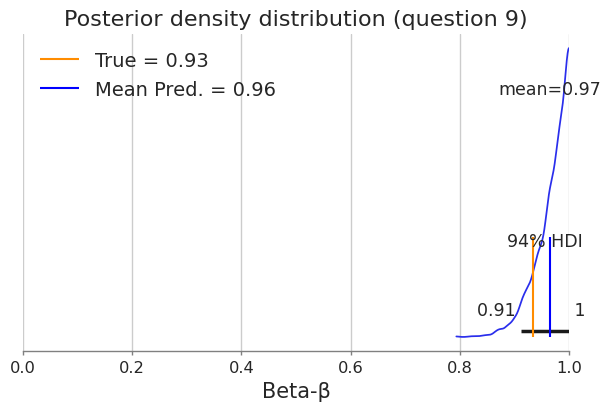

CORRECT


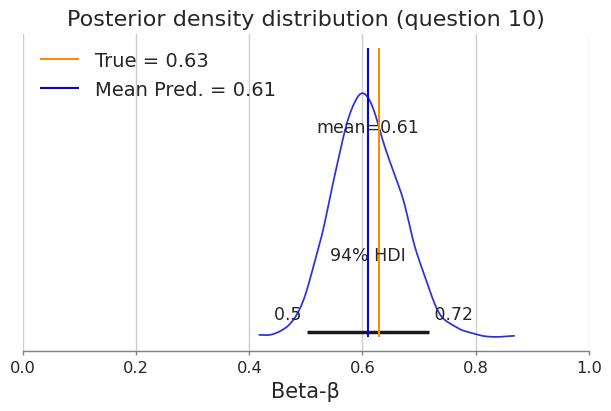

CORRECT


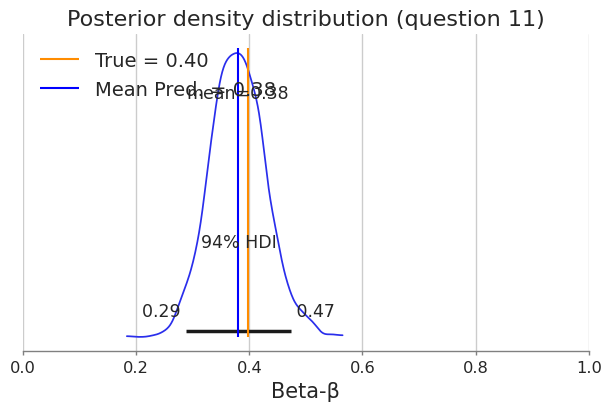

CORRECT


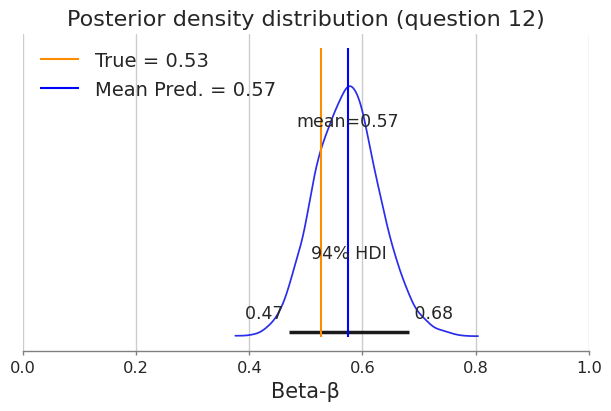

CORRECT


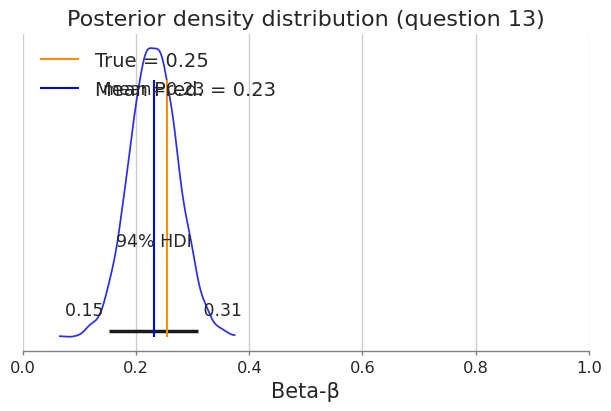

CORRECT


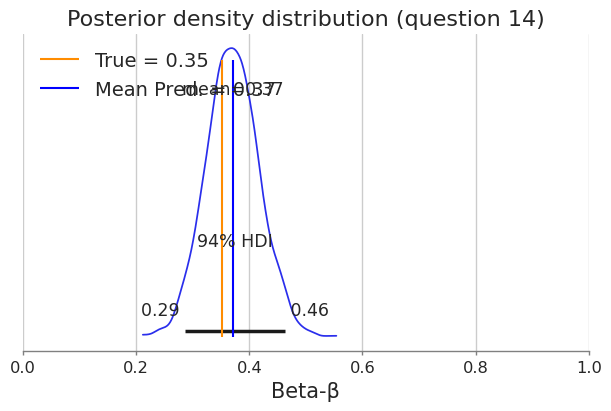

In [44]:
for i in range(n_questions):
    # difficulty
    difficulty = game_1.difficulty_questions[i]

    hdi_low = summary_posteriors.loc[f'Beta (questions)[{i}]'][f'hdi_low_{CI}']
    hdi_high = summary_posteriors.loc[f'Beta (questions)[{i}]'][f'hdi_high_{CI}']
    if hdi_low <= difficulty <= hdi_high:
      print('\033[1m' + '\033[92m' + 'CORRECT' + '\033[92m' + '\033[0m')
    else:
      print('\033[1m' + '\033[91m' + 'ERROR' + '\033[91m' + '\033[0m')

    questions_draws = trace.posterior['Beta (questions)'][:, :, i]
    
    az.plot_posterior(questions_draws, hdi_prob=CI, figsize=(6,4))
    x_line = difficulty
    plt.vlines(x=x_line, ymin=0, ymax=8, colors=['darkorange'], label=f'True = {x_line:.2f}')
    x_line_pred = summary_posteriors.loc[f'Beta (questions)[{i}]']['mean']
    plt.vlines(x=x_line_pred, ymin=0, ymax=8, colors=['blue'], label=f'Mean Pred. = {x_line_pred:.2f}')
    plt.legend(loc='upper left')
    plt.xlim([0, 1])
    plt.xlabel('Beta-β')
    plt.title(f'Posterior density distribution (question {i})')
    plt.grid(True)
    plt.show()